In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from ray.tune import Analysis
from src.data import MultiviewImgDataset, IFCNetPly, IFCNetNumpy
from src.models.models import MVCNN, SVCNN, DGCNN, MeshNet
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import transforms
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

In [3]:
data_root = Path("../data/processed/MVCNN/IFCNetCore")

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
transform = [
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
transform = transforms.Compose(transform)

train_dataset = MultiviewImgDataset(data_root, class_names, 12, partition="train", transform=transform)
val_dataset = MultiviewImgDataset(data_root, class_names, 12, partition="train", transform=transform)
test_dataset = MultiviewImgDataset(data_root, class_names,12, partition="test", transform=transform)

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, perm[:train_len])
val_dataset = Subset(val_dataset, perm[train_len:])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=8)

In [5]:
log_dir = Path("../logs/MVCNN/DEFAULT_2021-03-02_18-33-20//")
analysis = Analysis(log_dir, default_metric="val_balanced_accuracy_score", default_mode="max")
best_trial_dir = Path(analysis.get_best_logdir())

In [6]:
with (best_trial_dir/"params.json").open("r") as f:
    config = json.load(f)

svcnn = SVCNN(nclasses=len(class_names), pretrained=config["pretrained"], cnn_name=config["cnn_name"])
model = MVCNN(svcnn, nclasses=len(class_names), num_views=12, cnn_name=config["cnn_name"])
model_state, _ = torch.load(best_trial_dir/"checkpoint_59"/"checkpoint")
model.load_state_dict(model_state)

<All keys matched successfully>

In [7]:
device = torch.device("cuda")
model.to(device)

MVCNN(
  (net_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [8]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, labels in tqdm(loader):
            data, labels = data.to(device), labels.to(device)
            data = data.view(-1, *data.shape[-3:])

            outputs = model(data)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    print(result)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

100%|██████████| 486/486 [01:02<00:00,  7.83it/s]


{'accuracy_score': 0.9904761904761905, 'balanced_accuracy_score': 0.9926421047989127, 'precision_score': 0.9904971013830893, 'recall_score': 0.9904761904761905, 'f1_score': 0.9904300449632919}


(array([ 0,  8,  5, ...,  2, 19,  4]),
 array([[1.0000000e+00, 7.6563721e-14, 7.7183311e-15, ..., 1.7187534e-15,
         5.2912817e-13, 2.4784972e-14],
        [6.8396592e-21, 1.6351227e-16, 6.7511372e-13, ..., 1.3933824e-14,
         5.0629420e-16, 2.2772465e-16],
        [3.8202681e-15, 1.4586953e-19, 4.6712872e-16, ..., 5.9851096e-18,
         8.1730240e-20, 1.0434105e-17],
        ...,
        [1.6704637e-19, 1.1678988e-12, 9.9999988e-01, ..., 1.0059109e-15,
         4.2159403e-16, 1.4779792e-20],
        [3.6036619e-07, 5.5520154e-06, 1.1412640e-06, ..., 6.5766932e-07,
         2.8569582e-07, 9.9976760e-01],
        [1.6311028e-18, 3.7396182e-18, 4.0945091e-19, ..., 4.8232647e-17,
         8.4225473e-16, 1.1774304e-14]], dtype=float32))

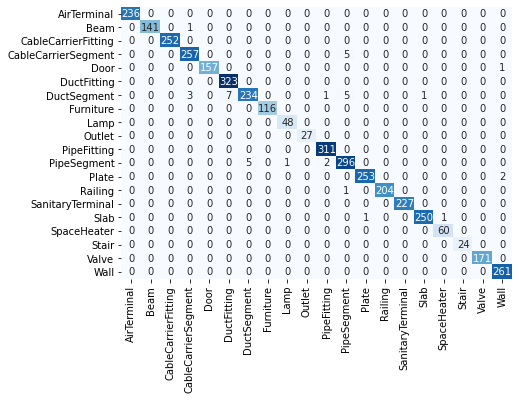

In [9]:
eval(model, train_loader, device, class_names)

100%|██████████| 209/209 [00:27<00:00,  7.72it/s]


{'accuracy_score': 0.9939975990396158, 'balanced_accuracy_score': 0.9954811356415505, 'precision_score': 0.9941041169845396, 'recall_score': 0.9939975990396158, 'f1_score': 0.9940006390089615}


(array([19, 14, 17, ..., 19, 19,  2]),
 array([[3.90573405e-07, 5.28578823e-07, 6.81879220e-09, ...,
         1.09365423e-08, 1.06414468e-08, 9.99982476e-01],
        [4.12360241e-05, 2.82323998e-10, 2.24300507e-07, ...,
         1.10349525e-08, 7.23577074e-08, 1.03047730e-08],
        [1.49393019e-20, 1.73608296e-16, 1.02447965e-12, ...,
         1.00000000e+00, 4.27310287e-13, 1.15478219e-18],
        ...,
        [5.56988455e-10, 2.74014922e-10, 1.07928139e-10, ...,
         3.29750853e-12, 7.68163224e-12, 9.99998927e-01],
        [5.23516732e-08, 7.20573894e-08, 3.72309450e-09, ...,
         3.49779694e-09, 2.32395458e-09, 9.99997854e-01],
        [2.85877704e-19, 7.30529135e-13, 1.00000000e+00, ...,
         2.40811857e-14, 3.49059588e-15, 6.65922533e-16]], dtype=float32))

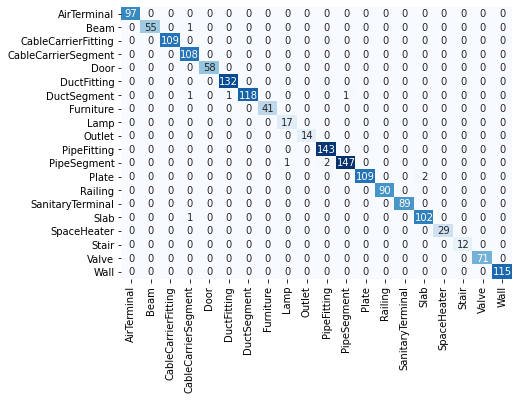

In [10]:
eval(model, val_loader, device, class_names)

100%|██████████| 298/298 [00:38<00:00,  7.80it/s]


{'accuracy_score': 0.869693148381673, 'balanced_accuracy_score': 0.8554361052525193, 'precision_score': 0.8747509814545653, 'recall_score': 0.869693148381673, 'f1_score': 0.8693084700684225}


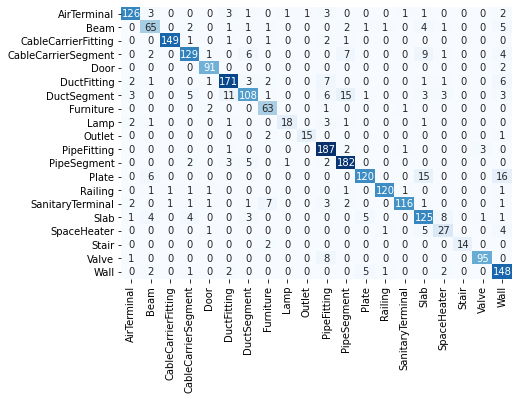

In [11]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/mvcnn_confusion.png")

In [12]:
np.savez("MVCNNProbs.npz", labels=test_labels, probs=test_probs)

In [13]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [14]:
wrong_pred_dir = Path("../data/external/MVCNN/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.filepaths[i][0].stem[:-2]}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.filepaths[i][0]
    shutil.copy(str(raw_data_dict[filename.stem[:-2]]), str(target_dir / f"{filename.stem[:-2]}_{prediction_str}.obj"))

074813d22a894bd299966b7fb2163749, Label: IfcAirTerminal, Prediction: IfcDuctSegment
1b198f2f3afd4ba680c37c41f55c84f7, Label: IfcAirTerminal, Prediction: IfcBeam
334a4570ea2c44748251140812d50117, Label: IfcAirTerminal, Prediction: IfcOutlet
59764e0479414af0a18096316ddd5681, Label: IfcAirTerminal, Prediction: IfcBeam
5c4c4a4d2a11431b92a19b0313f8ea68, Label: IfcAirTerminal, Prediction: IfcPipeFitting
71059417b8f4400ca102c84ae1a0f421, Label: IfcAirTerminal, Prediction: IfcSlab
7abfdf8a14054b8faed65bd520001e2d, Label: IfcAirTerminal, Prediction: IfcDuctFitting
7ac5c781e86644d1a9e95b8e2db000b0, Label: IfcAirTerminal, Prediction: IfcDuctFitting
923040fc07114eea990b70d042cfab18, Label: IfcAirTerminal, Prediction: IfcSanitaryTerminal
9914115ba0934432901fefa2e0dd0bc7, Label: IfcAirTerminal, Prediction: IfcLamp
b34c02ce21b9495ca1e0cc96e121a04f, Label: IfcAirTerminal, Prediction: IfcWall
d7b80e0c0d674bba93560731313787b5, Label: IfcAirTerminal, Prediction: IfcDuctFitting
d85b8309e61b4198ae023b28999